<p>Paper : https://chemrxiv.org/engage/chemrxiv/article-details/60c74146567dfe2305ec3d40 </p>
논문에서는 DCNN을 활용 / 이 코드에서는 다른 모델 사용

In [2]:
import time
import numpy as np
from sklearn.utils import shuffle
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import mixture, cluster
from sklearn import decomposition, manifold
import torch

dataset : https://drive.usercontent.google.com/download?id=10wo3fWl6lbD0p7S_gJ241BKJ05v6KL2U&authuser=1

In [3]:
import h5py
import pyUSID as usid

data = h5py.File('BFO-ts1-512.hdf5')
usid.hdf_utils.print_tree(data)

/
├ X_test
├ X_train
├ y_test
├ y_train


In [7]:
print(data['X_train'].shape, data['X_test'].shape)

(960, 256, 256, 1) (240, 256, 256, 1)


In [1]:
import torch
import EfficientNet
model = EfficientNet.EfficientNet(nb_classes=3)

x = torch.randn(1,1,256, 256).requires_grad_(False)
y = model(x)
y.shape

c:\Users\pmsda\anaconda3\envs\pycro_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pmsda\anaconda3\envs\pycro_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 3, 256, 256])

In [ ]:
# Code from https://github.com/jupyter-papers/FerroicBlocks.git
import torch.nn as nn
import torch.optim as optim
import os
import sys
from utils import generate_batches

sys.path.append(os.path.join(os.getcwd(),'FerroicBlocks'))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 5e-4)
hf_file = 'BFO-ts1-512.hdf5'
batch_size = 30

gen = generate_batches(hf_file, batch_size)
train_imgs, gt = next(gen.batch(0))
gen.close_()

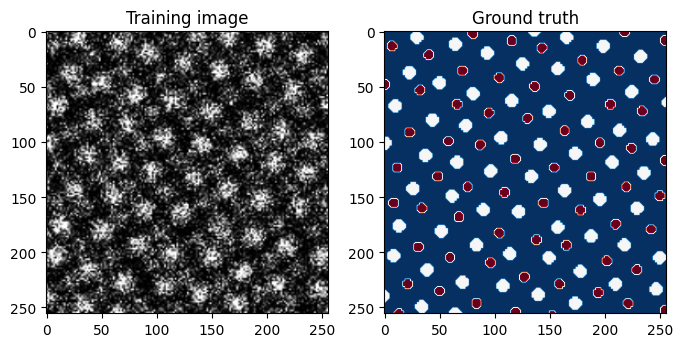

In [ ]:
import matplotlib.pyplot as plt

k = 0 # k는 0~29까지 / 총 30장 (batch_size)
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(train_imgs[k, 0, :, :], cmap='gray')
ax[0].set_title('Training image')
ax[1].imshow(gt[k], cmap='RdBu', interpolation='Gaussian')
ax[1].set_title('Ground truth')
plt.show()

In [47]:
from sklearn.utils import shuffle
# local에서 돌려서 10번만 돌렸다.
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses, test_losses = [], []

#[192 224 256 288 320] size 변화주며 학습시킴 np.arange(192,321,32)
gen = generate_batches(hf_file, batch_size, (256-64, 256+64+1, 32))
steps = gen.steps()
steps_val = gen.steps(mode = 'val')
# Train a model
for e in range(epochs):
    model.train()
    running_loss_train = 0
    steps = shuffle(steps)
    for i, s in enumerate(steps):
        print("\rTraining mode", 4*".",
              "Batch {}/{}".format(i+1, len(steps)),
              end = "")
        # get image-ground truth pair
        images, labels = next(gen.batch(s))
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_prob = model.forward(images)
        loss = criterion(log_prob, labels)
        running_loss_train += loss.item()
        loss.backward()
        optimizer.step()

    else:
        model.eval()
        running_loss_test = 0
        print()
        with torch.no_grad():
            for i, s in enumerate(steps_val):
                print("\rValidation mode", 4*".",
                      "Batch {}/{}".format(i+1, len(steps_val)),
                      end = "")
                images, labels = next(gen.batch(s, mode='val'))
                images, labels = images.to(device), labels.to(device)
                log_prob = model.forward(images)
                loss = criterion(log_prob, labels)
                running_loss_test += loss.item()
        train_losses.append(running_loss_train/len(steps))
        test_losses.append(running_loss_test/len(steps_val))

        # print statistics
        print("\nTraining loss: {:.4f}".format(train_losses[-1]),
             8*".", "Test loss: {:.4f}".format(test_losses[-1]))

    # save model weights if validation loss has decreased
    if e > 0 and test_losses[e] < min(test_losses[:e]):
        torch.save(model.state_dict(), 'best_weights.pt')

# save the final weights
torch.save(model.state_dict(), 'final_weights.pt')
gen.close_()

Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 1.0934 ........ Test loss: 1.0755
Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 1.0464 ........ Test loss: 1.0325
Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 0.9878 ........ Test loss: 0.9574
Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 0.9192 ........ Test loss: 0.8899
Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 0.8489 ........ Test loss: 0.8270
Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 0.7792 ........ Test loss: 0.7500
Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 0.7115 ........ Test loss: 0.6893
Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 0.6641 ........ Test loss: 0.6511
Training mode .... Batch 32/32
Validation mode .... Batch 8/8
Training loss: 0.6198 ........ Test loss: 0.6166
T

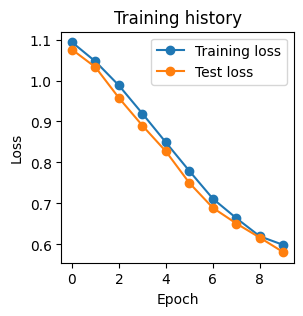

In [49]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(train_losses, '-o', label = 'Training loss')
ax.plot(test_losses, '-o', label = 'Test loss')
ax.set_title('Training history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc = 'upper right')